<a href="https://colab.research.google.com/github/shizuo-kaji/TutorialTopologicalDataAnalysis/blob/master/TopologicalDataAnalysisWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools for Topological Data Analysis
In this notebook, we will see
- What TDA offers for practitioners (Dimensiona reduction&Visualisation, Feature extraction)
- What types of input each method accepts (Point cloud, Image, Time series)
- How different tools can be used in coordination
- Some seeds for new research directions

This notebook is written by Shizuo KAJI
and maintained [here](https://github.com/shizuo-kaji/TutorialTopologicalDataAnalysis).

In [1]:
## If you do not have the necessary libraries installed, run this cell (only for once)
# Be patient! It takes a few minutes.
## If you are running this notebook locally, to install standard libraries such as numpy, scipy, scikit-learn
# I recommend to use the package manager "conda". e.g.,  "conda install scikit-learn"
!pip install ripser umap-learn kmapper persim PersistenceImages
!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install tomaster Boruta
!pip install gudhi


     |████████████████████████████████| 71kB 10.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 133kB 42.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 1.2MB 42.8MB/s 
  Created wheel for ripser: filename=ripser-0.6.0-cp37-cp37m-linux_x86_64.whl size=454926 sha256=6b96b19ab56a4736d9aa0f6e62fd7f2c9e44b3907694a7708c85768386068546
  Stored in directory: /root/.cache/pip/wheels/95/1e/13/59da989de59903698d767dcb19414163e683a2dd31edf80417
Successfully built ripser
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=edbcaaca911e739a5ccf861e8110df3b1a8654be9e93e84f0f3cc504f226c76c
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for PersistenceImages

In [2]:
# load necessary libraries
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import glob,os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
import persim
import gudhi


In [ ]:
## For Google Colab,
# you can also use the "Files" tab on the left.
# alternatively, to upload a file

#!ls
#from google.colab import files
#uploaded = files.upload()
#files.download('kepler-mapper-output.html')


sample_data


## Feature extraction from different data types

### Point cloud

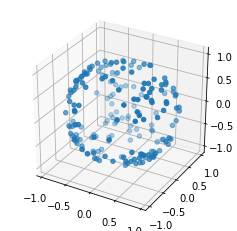

In [3]:
## create random data on 2-sphere
X = np.random.rand(200,3)-0.5  # 200 random points in [-0.5,0.5]^3
X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True)) # normalize to have the unit length
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

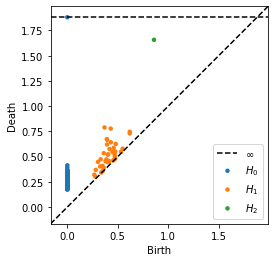

In [4]:
## compute persistent homology (PH) of the Vietoris-Rips (VR) complex and plot the persistence diagram (PD)
## VR-complex has a huge number of simplices. So the maximum number of points is in the order of 1000.
## You can compute an approximated PH by setting, e.g., "n_perm=100" (sub-sampling 100 points which are far apart).
diag = ripser(X,maxdim=2,n_perm=100)['dgms']
persim.plot_diagrams(diag)

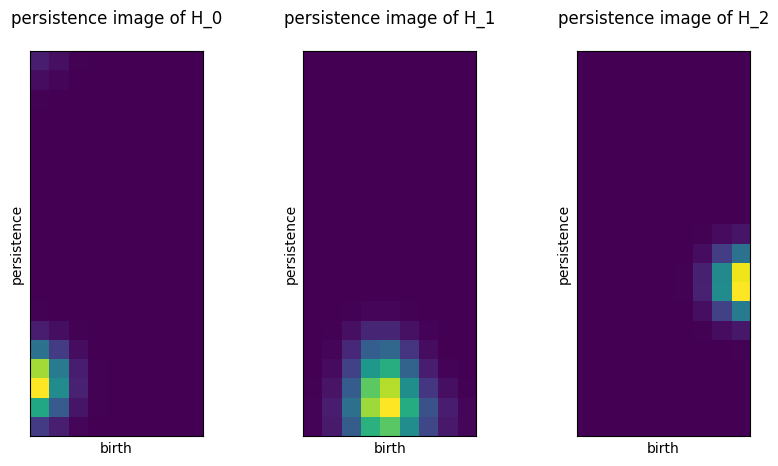

In [5]:
# plot with Persistence Image
# look at https://persim.scikit-tda.org/en/latest/reference/stubs/persim.PersistenceImager.html for weighting options
min_birth, max_death = 0,2
dclip = [np.clip(d,min_birth, max_death) for d in diag]
pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
pimgr.fit(dclip, skew=True)
pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

plt.figure(figsize=(10,5))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    pimgr.plot_image(pimgs[i], ax)
    plt.title("persistence image of H_{}".format(i))


usetex mode requires TeX.


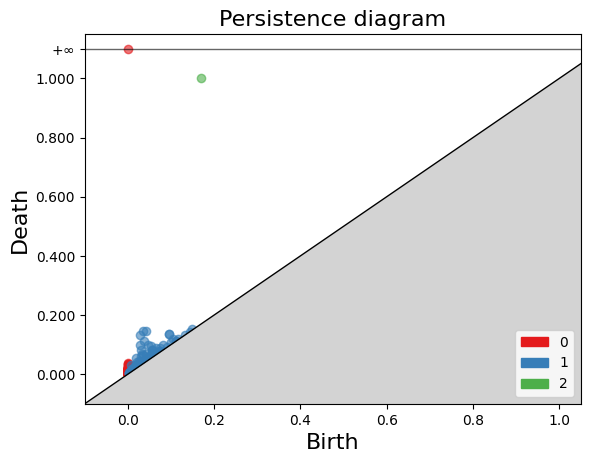

In [6]:
## from a point cloud, we can construct different complexes.
# The choice affects performance and the result, so we have to give a careful consideration
# Let's see an example of alpha complex.

simplex_tree = gudhi.AlphaComplex(points=X).create_simplex_tree()
diag = simplex_tree.persistence()

# We observe a notable difference in H_1 compared to the result of the VR complex above
gudhi.plot_persistence_diagram(diag, legend=True)

#!pip install cechmate  ## C++ compilers are required on the system
#import cechmate as cm
#alpha = cm.Alpha()
#filtration = alpha.build(X)
#dgmsalpha = alpha.diagrams(filtration)
#persim.plot_diagrams(dgmsalpha)

### Distance between persistent diagrams
- classification/visualisation example

In [10]:
# sampling points from sphere and cube
def sample_sphere(n,radius=1):
    X = np.random.rand(n,3)-0.5
    X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True))
    X *= radius
    X += np.random.normal(scale=0.2,size=(len(X),3))
    X += np.random.uniform(-1,1,3)
    return(X)
def sample_cube(n,radius=1):
    X = 2*np.random.rand(n,3)-1
    X *= radius
    X += np.random.uniform(-1,1,3)
    return(X)
    

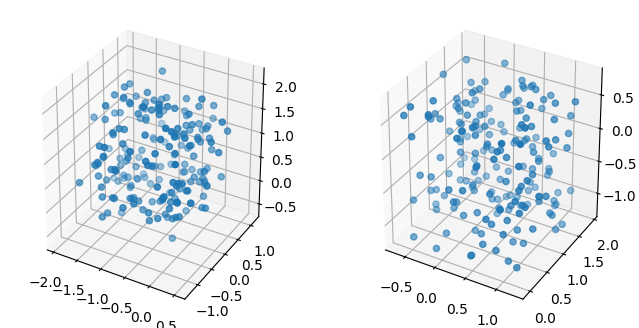

In [11]:
## create point clouds from sphere and cube and compute pairwise bottleneck distance of PH
n=5   # number of spheres (cubes). In total, we'll have 2n sets of point clouds.
X=[sample_sphere(200) for i in range(n)]
Y=[0]*n
X.extend([sample_cube(200) for i in range(n)])
Y.extend([1]*n)

## Plot the point clouds: for human eyes, it is not very easy to distinguish 3d point clouds
# sphere
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[0][:, 0], X[0][:, 1], X[0][:, 2])
# cube
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[n][:, 0], X[n][:, 1], X[n][:, 2])

# compute PH and distance
pd = []
for i in range(2*n):       
    pd.append(ripser(X[i],maxdim=2,n_perm=100)['dgms'][2])

D = np.zeros((2*n,2*n))
for i in range(2*n-1):
    for j in range(i+1,2*n):
        D[i,j]=persim.bottleneck(pd[i], pd[j])


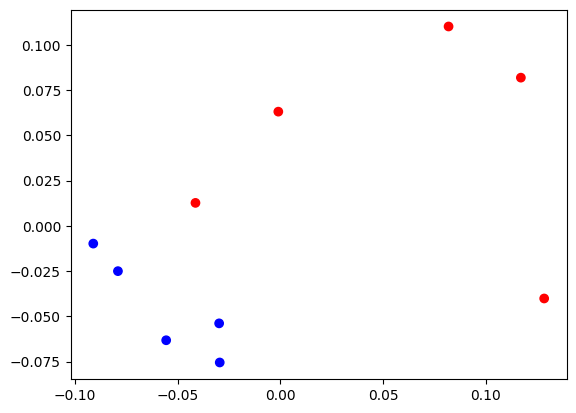

In [9]:
## Bottleneck distance discern spheres from cubes
# We obtain the distance matrix for point clouds, and thus, a finite metric space with 2n points.
# For visualisation, we use Multi-dimensional scaling, a method to embed a finite metric space into a Euclidean space
# Blue dots represent cubes, red dots represent spheres
from sklearn.manifold import MDS
mds = MDS(n_components=2,dissimilarity='precomputed')
D = D+D.T
X_mds = mds.fit_transform(D)
col = ['r','b']
plt.scatter(X_mds[:,0],X_mds[:,1],c=[col[y] for y in Y])

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT
Distances
Bottleneck (GUDHI-hera) with L-infty metric: 6.499999999999999
Bottleneck (persim) with L-infty metric: 6.5
2-Wasserstein (GUDHI-hera) with L-infty metric: 12.504999999999999
2-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 17.684740597475553
99-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 9.192421749823405
99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance): 6.500023754826838


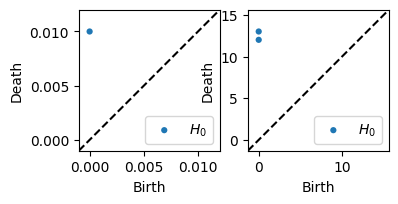

In [12]:
## Remark on Bottleneck and p-Wasserstein distances
# We have two parameters for Wasserstein distance: the exponent p and the metric for the underlying space.
import gudhi,gudhi.hera,gudhi.wasserstein,persim
X,Y =np.array([[0., 0.01]]), np.array([[0., 13.],[0.,12.]])
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(121)
persim.plot_diagrams(X, ax=ax)
ax = fig.add_subplot(122)
persim.plot_diagrams(Y, ax=ax)

print("Distances")
print("Bottleneck (GUDHI-hera) with L-infty metric:", gudhi.bottleneck_distance(X,Y))
print("Bottleneck (persim) with L-infty metric:", persim.bottleneck(X,Y))
#print(gudhi.wasserstein.wasserstein_distance(X, Y, order=1, internal_p=2)) ## requires pot
print("2-Wasserstein (GUDHI-hera) with L-infty metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=np.inf))
print("2-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance):", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=np.inf))



### point cloud in an ambient metric space 

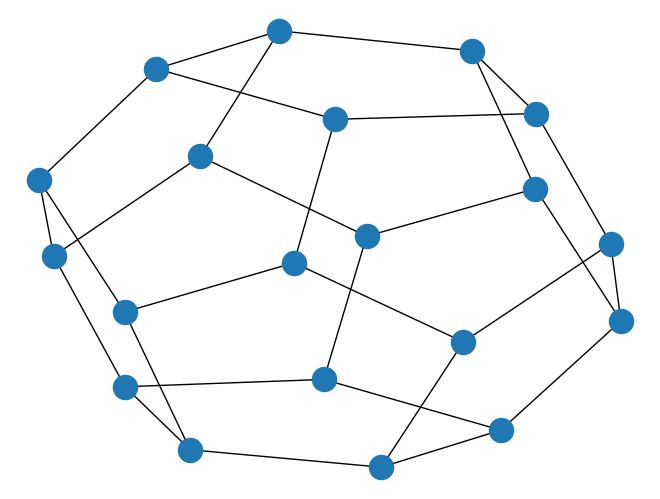

In [13]:
## VR complex can also be constructed from an abstract distance matrix, not necessaliry from a point cloud in a Euclidean space.
# We give an example of a graph distance
import networkx as nx
G=nx.dodecahedral_graph()
nx.draw(G)
D=np.array(nx.floyd_warshall_numpy(G)) # distance matrix


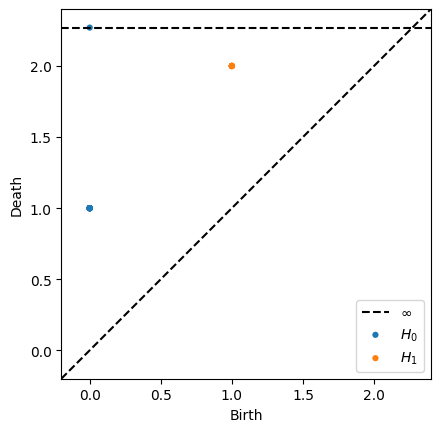

In [14]:
# compute persistence of a distance matrix
diag = ripser(D,distance_matrix=True)['dgms']
persim.plot_diagrams(diag)

# (A direction of new research) An interesting question is:
# for a set of point clouds (or images), we can first compute PD for each point cloud and then compute the distance matrix of PDs.
# PH of the distance matrix defines a feature for "a set of point clouds".
# Do we have a practical application?
# for example: we have multiple measurements for objects from each class, and each measurement yields PH.
# in this case, "PH of PD" provides a collective feature for the objects beloging to the class.

### Trajectory of cycles in a sequence of PD

(A direction of new research)
Tracking cycles over time should be done by looking at cycle representatives.
However, a quick-and-dirty way is to use the matching used in the Wasserstein distance (optimal transport).
We demonstrate this method with a series of PDs of computed from a series of point clouds.


In [15]:
# sample from Figure 8
def create_figure8(num_samples=200):
  t = np.linspace(0, 2*np.pi, num=num_samples)
  X = np.stack((np.sqrt(2)*np.cos(t) / (np.sin(t)**2+1), np.sqrt(2)*np.cos(t)*np.sin(t) / (np.sin(t)**2+1))).T
  X += 0.1*np.random.random(X.shape)
  return(X)

In [16]:
# create a sequence of figure8 with varying scale
# and compute their PD
Xs = []
diags = []
frames = 30
for fr in range(frames):
  a = frames/2
  X = create_figure8() * (a**2-(fr-a)**2)/(a**2)
  Xs.append(X)
  diags.append(ripser(Xs[fr],maxdim=1,n_perm=100)['dgms'])

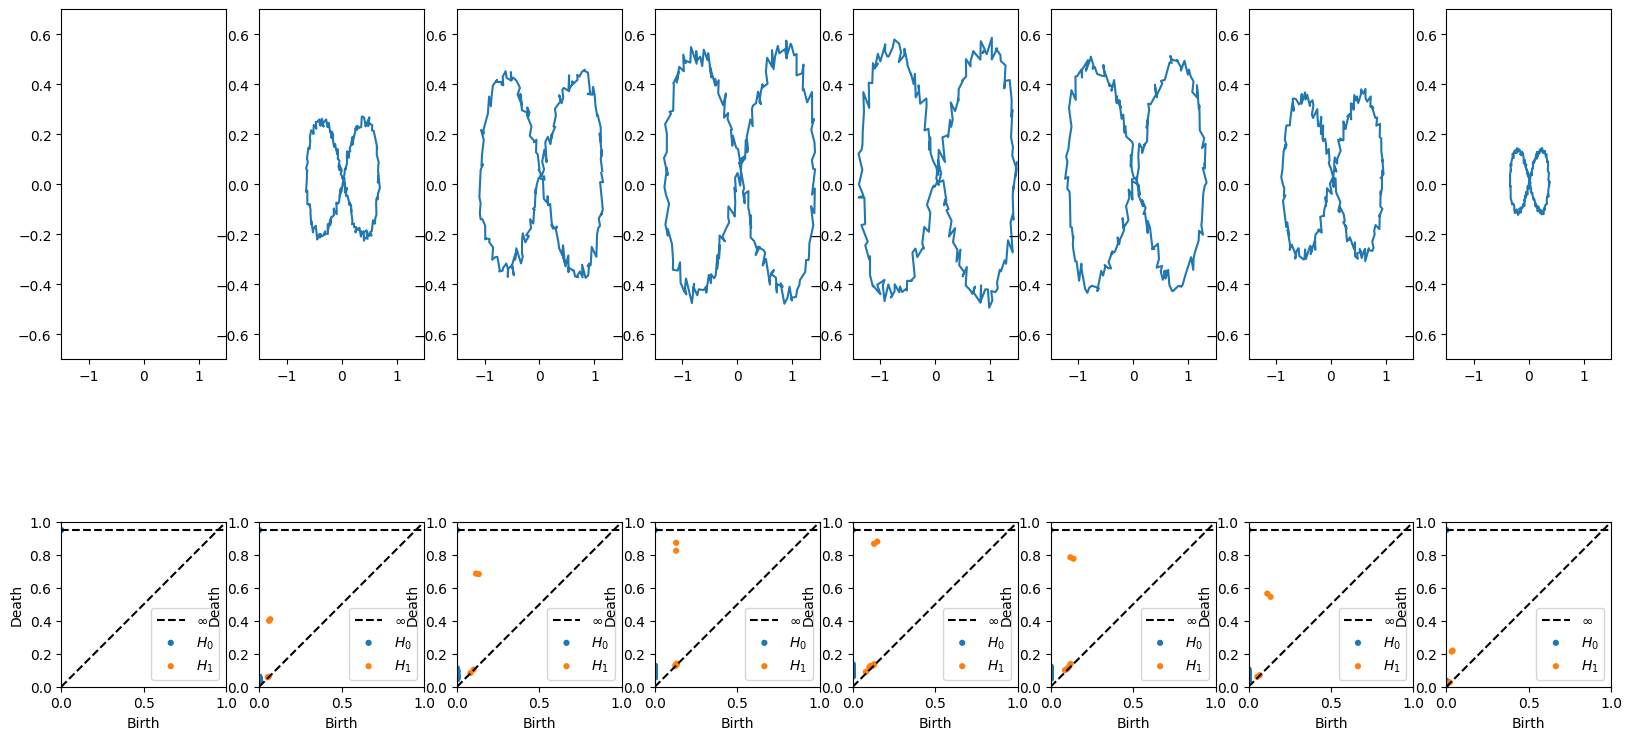

In [25]:
# plot some of the samples
from mpl_toolkits.axes_grid1 import ImageGrid
num_disp=7
fig = plt.figure(figsize=(20, 10))
i=0
for x,dg in zip(Xs[::(len(Xs)//num_disp)],diags[::(len(Xs)//num_disp)]):
    un = len(Xs[::(len(Xs)//num_disp)])
    ax = fig.add_subplot(2,un,i+1)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-0.7,0.7)
    ax.plot(*x.T)
    persim.plot_diagrams(dg,xy_range=(0,1,0,1),ax=fig.add_subplot(2,un,i+1+un))
    i=i+1

In [38]:
# match cycles between adjacent frames and plot their trajectories
import matplotlib.colors as colors
import matplotlib.cm as cm
def cycle_trajectory(diags,dim):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.xlim(0,0.3)
  plt.ylim(0,1)
  usercmap = plt.get_cmap('jet')
  cNorm  = colors.Normalize(vmin=0, vmax=len(diags))
  scalarMap = cm.ScalarMappable(norm=cNorm, cmap=usercmap)
  for i in range(len(diags)-1):
    D1 = diags[i][dim]
    D2 = diags[i+1][dim] 
    d, M= persim.wasserstein(D1,D2,matching=True)
    for m in M:
      m0 = int(m[0]) # matched ids
      m1 = int(m[1])
      if -1<m0<len(D1) and -1<m1<len(D2):
        plt.plot( [D1[m0][0], D2[m1][0]],[D1[m0][1], D2[m1][1]],  'r-', lw=1)
#        plt.plot(*D1[m0],'ko')
        plt.plot(*D2[m1],'o',color = scalarMap.to_rgba(i))
  plt.colorbar(scalarMap)
  plt.show()

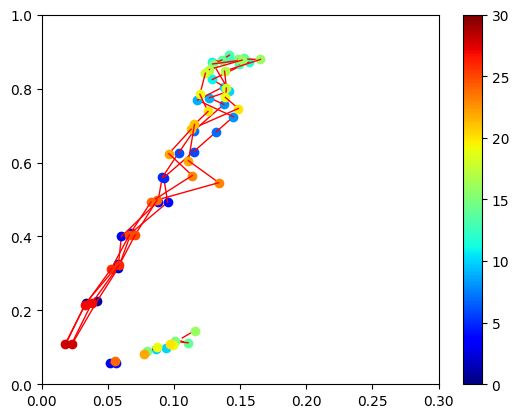

In [39]:
## visualise H_1 trajectory
# blue: early frame => red: late frame
# we can observe that two cycles emerge and grow (to longer lifetime) and then follow the path back to finally disapear.
# the points with low lifetime are noise
cycle_trajectory(diags,dim=1)

### Image and Volume

0 255 uint8


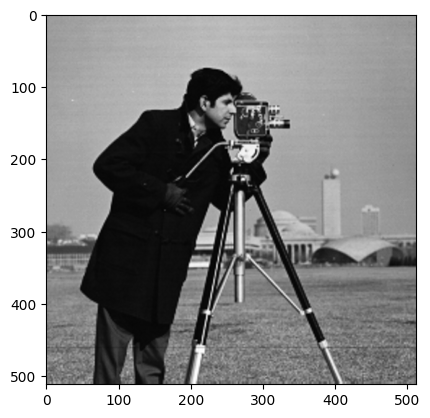

In [ ]:
## greyscale photo
import skimage
from skimage import io
from PIL import Image
import cripser
# load a sample image
img = skimage.data.camera()
## if you want to upload your own image to Google Colab
#from google.colab import files
#img = skimage.color.rgb2gray(io.imread(list(files.upload().keys())[0]))

# plot
plt.imshow(img, cmap='gray')
print(np.min(img),np.max(img),img.dtype)

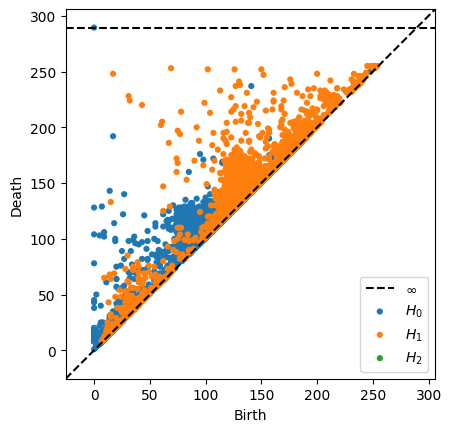

In [ ]:
## compute persistence of the sublevel filtration
pd = cripser.computePH(img,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

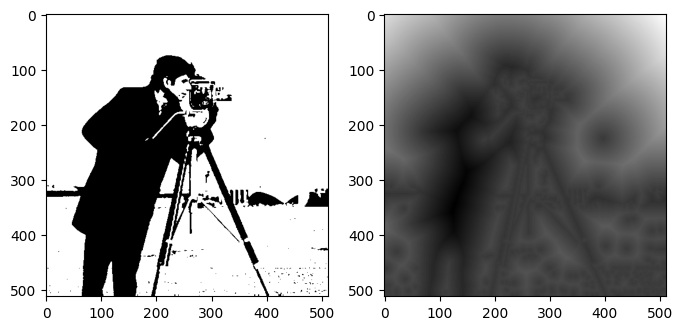

In [ ]:
## For greyscale images, we have another notion of persistence than the sublevel filtration
# the following function makes the input image binary and apply distance transform
# the sublevel filtration is suitable when pixel values have significant meaning in your data (like the HU value in CT)
# while the distance transform is suitable when you are interested in the scale of the geometric structure in your data.
from scipy.ndimage.morphology import distance_transform_edt
from skimage.filters import threshold_otsu
bw_img = (img >= threshold_otsu(img))
dt_img = distance_transform_edt(bw_img)-distance_transform_edt(~bw_img)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(bw_img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(dt_img, cmap='gray')

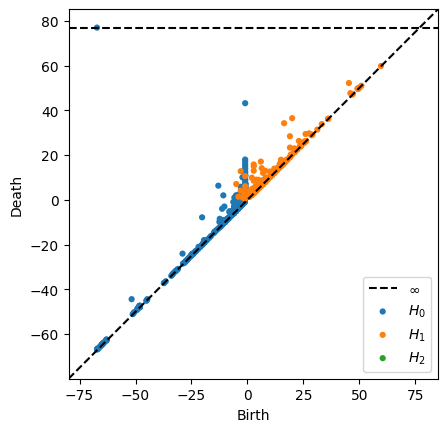

In [ ]:
# compute persistence of the distance transform
pd = cripser.computePH(dt_img,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

In [ ]:
## compute the heatmap of cycles with specified birth-death properties
# the heatmap image reveals what kind of image features are captured by PH


from scipy.ndimage.filters import convolve
# gaussian kernel for convolution
def gaussian(h,sigma):
    x = np.arange(-h[0],h[0],1)
    y = np.arange(-h[1],h[1],1)
    z = np.arange(-h[2],h[2],1)
    xx, yy,zz = np.meshgrid(x,y,z)
    return(np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2)).astype(np.float32))

def heat_map(img,pd,h=3,sigma=1,min_life = 10,max_life =255,min_birth = 0,max_birth = 255,dimension = 0,life_weighted=True,location='birth'):
  if len(img.shape)==2:
    mx,my=img.shape
    mz = 1
    kernel = gaussian([h,h,1],sigma)
  else:
    mx,my,mz=img.shape
    kernel = gaussian([h,h,h],sigma)

  selected_cycle = np.zeros((mx,my,mz))
  ppd = pd[pd[:,0] == dimension]
  ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
  ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
  ppd = ppd[min_birth < ppd[:,1]]
  ppd = ppd[ppd[:,1] < max_birth]
  w = 1
  for c in ppd:
      if location=='birth':
        x,y,z=int(c[3]),int(c[4]),int(c[5])
      else:
        x,y,z=int(c[6]),int(c[7]),int(c[8])
      if life_weighted:
        w = c[2]-c[1]
      #selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += w
      selected_cycle[x,y,z] += w
  #print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))
  cycle_conv = convolve(selected_cycle,kernel)
  #print(np.min(cycle_conv),np.max(cycle_conv),np.sum(cycle_conv))
  return(np.squeeze(cycle_conv))



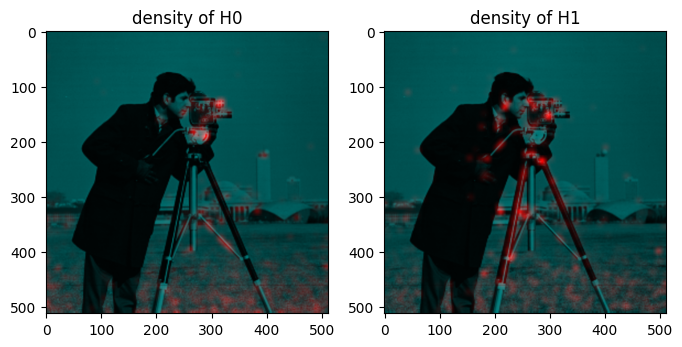

In [ ]:
## Plot heatmap for H_0 and H_1
pd = cripser.computePH(img,maxdim=1,location="birth")
fig = plt.figure(figsize=(8, 4))
for i in range(2):
  heat=heat_map(img,pd,h=10,sigma=5,min_birth=10,dimension=i)
  heat = (heat/np.max(heat) * 255).astype(np.uint8)
  ax = fig.add_subplot(1,2,i+1)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density of H{}".format(i))


(512, 512, 8) 0.0 1.0


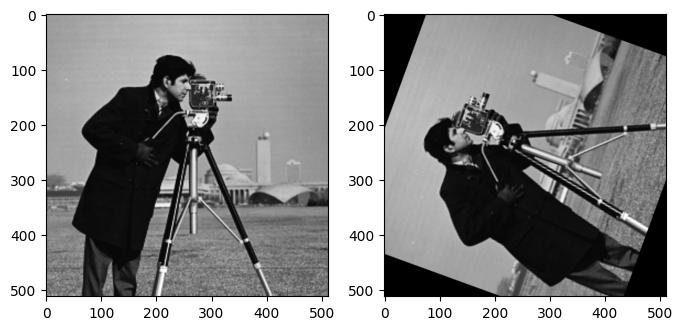

In [ ]:
## 3D volume 
# create a dummy volume by stacking rotated greyscale images
from skimage.transform import rotate
vol = np.dstack([rotate(img, 10*i) for i in range(8)])

## load jpg files from disk and stack into a 3D array of type float64
#files = sorted([f for f in glob.glob("*.jpg")])
#vol = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')

# plot the first and the last slices
print(vol.shape, np.min(vol),np.max(vol))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(vol[:,:,0],cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(vol[:,:,-1], cmap='gray')

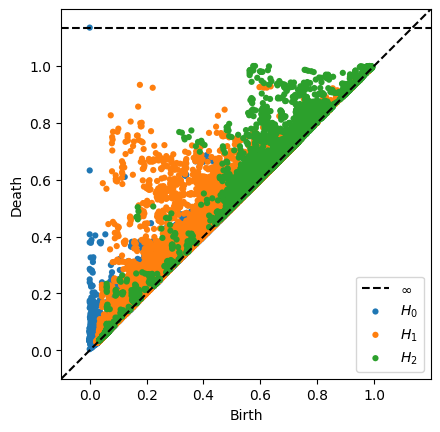

In [ ]:
## compute persistence of the sublevel filtration of the volumetric image
pd = cripser.computePH(vol,maxdim=2,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

### Time series
Time series is a 1D image so basically the techniques in the previous section apply straightforwardly.
Here, we see examples with different tasks.

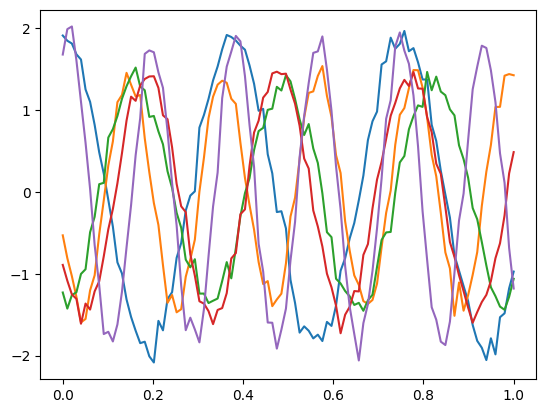

In [ ]:
# synthetic example: 
# Goal: to infer the period of sine curve from noisy data
n=200  # number of samples
t = np.linspace(0,1,100)
a=np.random.uniform(low=1,high=2,size=n)  # amplitude
b=np.random.uniform(low=1.5,high=7,size=n) # period <= our target for regression
c=np.random.uniform(low=-np.pi,high=np.pi,size=n) # phase
# create different sine curves with noise
X = [a[i]*np.sin(2*np.pi*b[i]*t+c[i]) + np.random.normal(scale=0.1,size=len(t)) for i in range(n)]
for i in range(5):
    plt.plot(t,X[i])

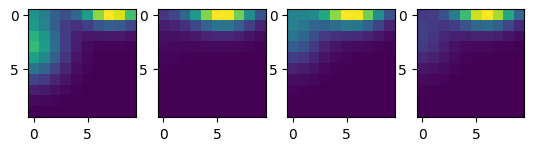

In [ ]:
## compute PH and vectorise by persistence image
import persim,cripser
import PersistenceImages.persistence_images as pimg

#pim=persim.PersImage(pixels=[10,10], spread=1) ## for persim
pim = pimg.PersistenceImager(birth_range=(0,5), pers_range=(0,5), pixel_size=0.5)
#print(pim)
pds, pims = [], []
for i in range(len(X)):
    pd = cripser.computePH(X[i])[:,1:3]    # compute PH
    pds.append(np.clip(pd,a_min=-2,a_max=2))  # clip min/max birth/death
    pims.append(pim.transform(pds[i])) # vectorise by persistence image
for i in range(4):   # plot persistence images
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i])
    #pim.show(pims[i], ax) ## for persim

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05371837878090524, tolerance: 0.03170925432723022
  positive)


MSE train : 0.078, test : 0.079
R2 train : 0.966, test : 0.968


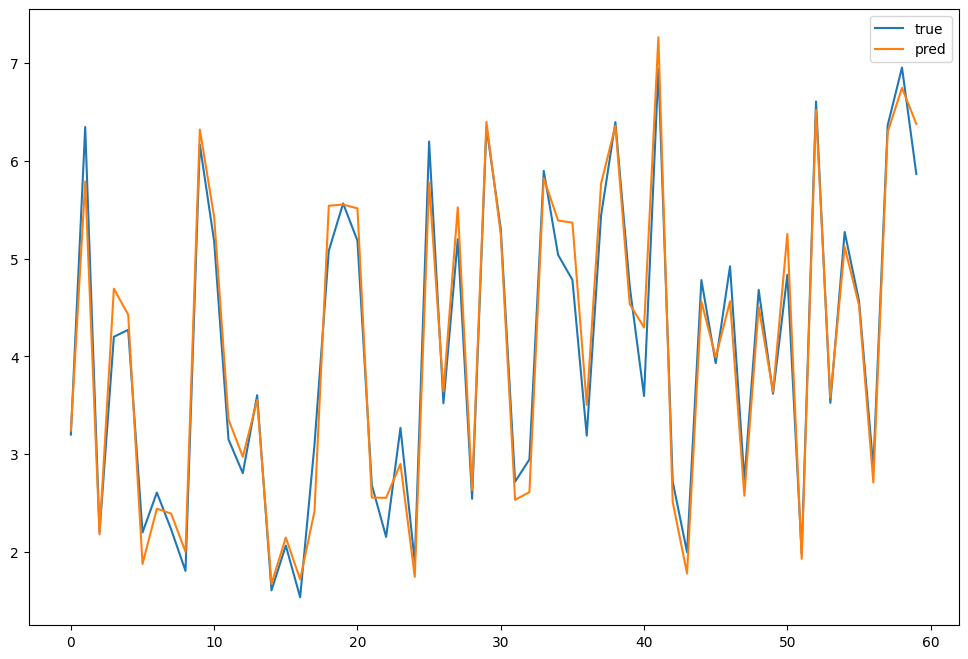

In [ ]:
# linear regression for the period with Lasso
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# fit model
clf = linear_model.Lasso(alpha=0.0001,normalize=True,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is reasonably good
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

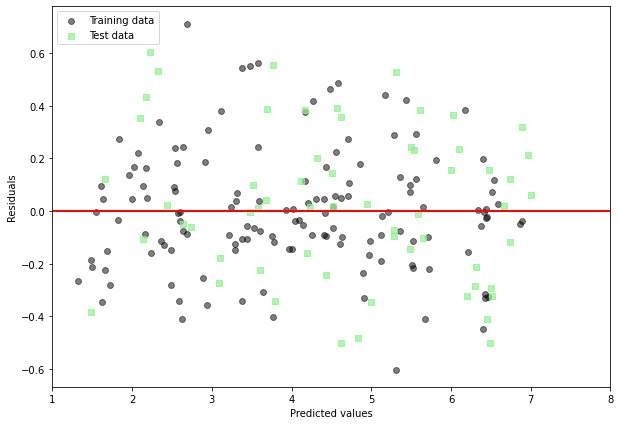

In [ ]:
# residual plot
plt.figure(figsize = (10, 7))
plt.scatter(trainPred, trainPred - trainY, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(testPred, testPred - testY, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 1, xmax = 8, lw = 2, color = 'red')
plt.xlim([1, 8])
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10952822088358971, tolerance: 0.032625440391845194
  positive)


MSE train : 0.656, test : 5.241
R2 train : 0.718, test : -1.027


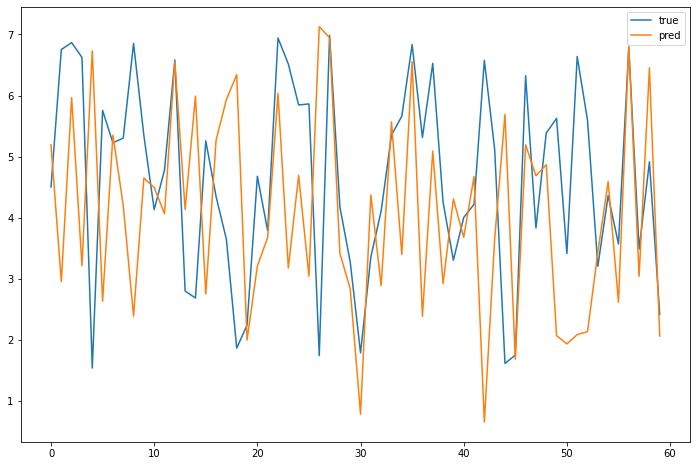

In [ ]:
## If we use the original data directly instead of PH
(trainX, testX, trainY, testY) = train_test_split(X, b, test_size = 0.3, random_state = 0)  # see what happens if we use the input data directly

# fit model
clf = linear_model.Lasso(alpha=0.0001,normalize=True,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is much worse!
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.050, test : 0.299
R2 train : 0.978, test : 0.877


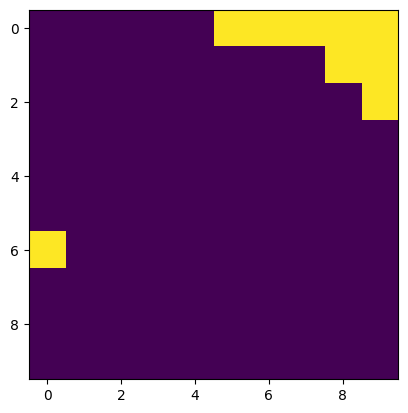

In [ ]:
## non-linear feature selection with RandomForest
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# feature selection with Boruta: takes a few minutes
rf = RandomForestRegressor(n_jobs=-1,n_estimators=50,max_depth=15)
feat_selector = BorutaPy(rf, verbose=0)
feat_selector.fit(trainX, trainY)
#print(feat_selector.ranking_)

X_filtered = feat_selector.transform(trainX)
rf.fit(X_filtered, trainY)
trainPred = rf.predict(X_filtered)
testPred = rf.predict(feat_selector.transform(testX))
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# plot selected region in persistent image
plt.imshow(feat_selector.support_.reshape(pims[0].shape))


In [ ]:
## Let's compare with LSTM (a popular version of recurrent neural network)
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(X).reshape(n,-1,1), b, test_size = 0.3, random_state = 0)

# LSTM model definition
num_hidden_units = 128
model = Sequential()
model.add(LSTM(
    num_hidden_units,
    input_shape=(len(t), 1),
    return_sequences=False))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))
model.summary()

# train
model.fit(trainX, trainY, batch_size=5, epochs=100,
    validation_split=0.1,   ## isn't it unfair?
    callbacks=[EarlyStopping(monitor='val_loss', mode='auto', patience=20)]
)

# prediction: LSTM performs better
trainPred = model.predict(trainX)
testPred = model.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )
plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

## Dimension reduction
Dimension reduction techniques can be used for
- Visualisation
- as a preprocess for regressor/classifier
- outlier detection

(901, 64)


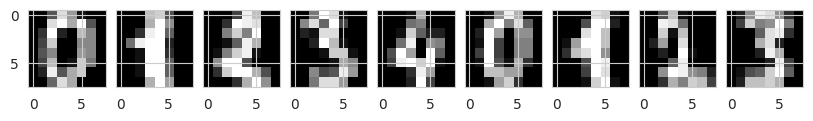

In [ ]:
# load demo data: hand written digits
import sklearn
import sklearn.datasets
from scipy import stats
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
# seaborn makes matplot drawing charming
import seaborn as sns
sns.set_style("whitegrid")

X,Y = sklearn.datasets.load_digits(n_class=5,return_X_y=True)
print(X.shape)
num_disp=9
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111,nrows_ncols=(1, num_disp),axes_pad=0.1)
for ax,x in zip(grid, X[:num_disp]):
    ax.imshow(x.reshape(8,8),cmap="gray")


### Visualisation

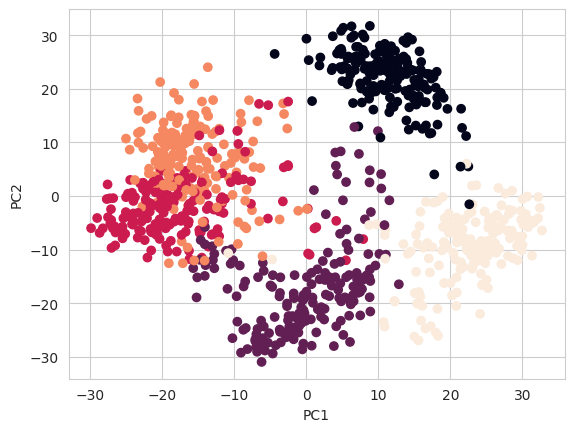

In [ ]:
## everyone's favourite PCA: indeed, it is not so bad though there are some overlaps
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
# plot first and second primary components
plt.scatter(X_pca[:,0],X_pca[:,1],c=Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

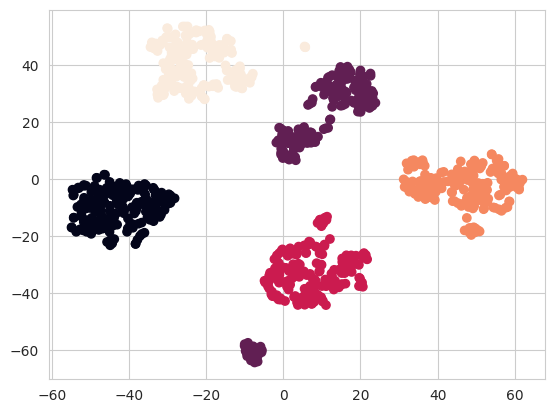

In [ ]:
# t-SNE: one of the most popular method. Excellent for preprocess but the meaning of the components are less clear 
X_tsne = manifold.TSNE(n_components=2,perplexity=20).fit_transform(X)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=Y)


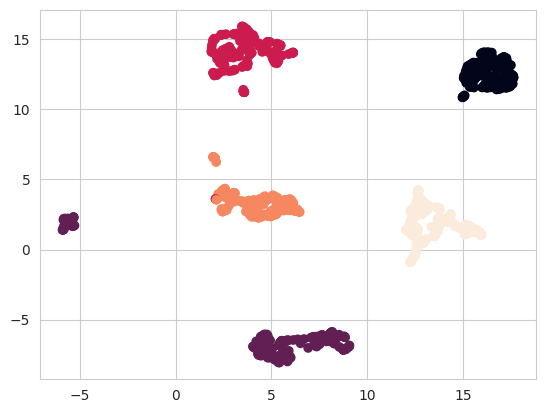

In [ ]:
# Universal Manifold Learning (umap): projects vectors while keeping the topology
import umap
X_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='euclidean').fit_transform(X)
plt.scatter(X_umap[:,0],X_umap[:,1],c=Y)

Download kepler-mapper-output.html and open it with a browser to see the results.


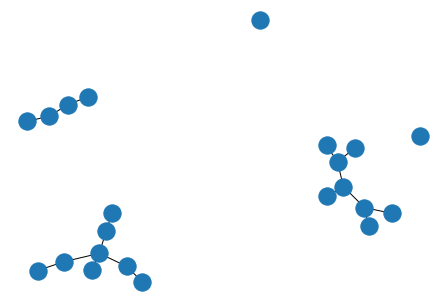

In [ ]:
## Mapper: good for revealing rich topology but difficult to tune
# the visualisation does not work with Google Colab. Please use Jupyter-notebook
import kmapper, kmapper.jupyter
from sklearn.preprocessing import StandardScaler
import networkx as nx

km = kmapper.KeplerMapper()
X_std = StandardScaler().fit_transform(X)   # standardise
f = km.project(X_std,projection="sum") # we have to choose a 1-dim projection
graph = km.map(lens=f, X=X_std, clusterer=sklearn.cluster.DBSCAN(metric="cosine",algorithm='auto', eps=0.3, leaf_size=10))
nx.draw(kmapper.adapter.to_nx(graph))
km.visualize(graph, color_function=Y, custom_tooltips=Y, path_html="kepler-mapper-output.html") # To download the output, look at the beginning of this note
print("Download kepler-mapper-output.html and open it with a browser to see the results.")
# the following rich visualisation does not work with Google Colab.
# download "kepler-mapper-output.html" and open it locally with a browser
#kmapper.jupyter.display(path_html="kepler-mapper-output.html")

### Classification

In [ ]:
## classification with Randomforest
# first, directly with the vector data (image pixel values)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# train-test split
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.3, random_state = 0)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)

# classification results
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 51  2  5  3]
 [ 0  2 54  3  0]
 [ 0  1  3 47  1]
 [ 1  0  0  0 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.94      0.84      0.89        61
           2       0.92      0.92      0.92        59
           3       0.85      0.90      0.88        52
           4       0.92      0.98      0.95        47

    accuracy                           0.92       271
   macro avg       0.92      0.93      0.92       271
weighted avg       0.92      0.92      0.92       271



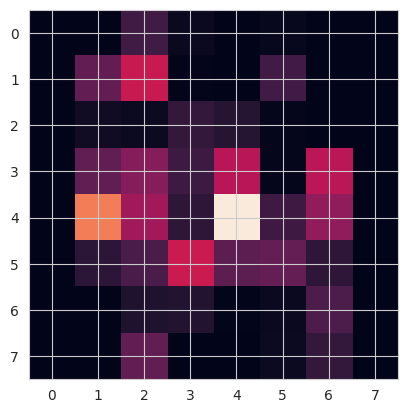

In [ ]:
## identify what variables have impact on the decision
# in this case, which pixels are important to distinguish digits
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.imshow(clf.feature_importances_.reshape(8,8))

In [ ]:
## Now, first dimension reduction (64 -> 5) and classify
# You'll observe the accuracy gets better!
X_umap = umap.UMAP(n_components=5, n_neighbors=5, metric='euclidean').fit_transform(X)
(trainX, testX, trainY, testY) = train_test_split(X_umap, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 61  0  0  0]
 [ 0  0 59  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        47

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [ ]:
## for comparison, use persistence image as a feature extractor and do classification
# We see it is insufficient to look at PH in this case; only digit 0 can be classified with a reasonable accuracy
pim = pimg.PersistenceImager(birth_range=(0,3), pers_range=(0,3), pixel_size=0.5)
pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i].reshape(8,8)
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(~bw_img)
    pd = cripser.computePH(dt_img)    # compute PH of distance transform
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=0,a_max=3) # clip min/max birth/death
    pds.append(pd)  
    pim0 = pim.transform(pd[pd[:,0]==0,1:3])
    pim1 = pim.transform(pd[pd[:,0]==1,1:3])
    pims_h0.append(pim0.ravel()) # vectorise by persistence image
    pims_h1.append(pim1.ravel()) # vectorise by persistence image

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[43  0  0  9  0]
 [ 0  0  0 61  0]
 [ 0  0  0 59  0]
 [ 1  0  0 51  0]
 [ 5  0  0 42  0]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        59
           3       0.23      0.98      0.37        52
           4       0.00      0.00      0.00        47

    accuracy                           0.35       271
   macro avg       0.22      0.36      0.24       271
weighted avg       0.21      0.35      0.23       271



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Confusion matrix
 [[29  0]
 [ 0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



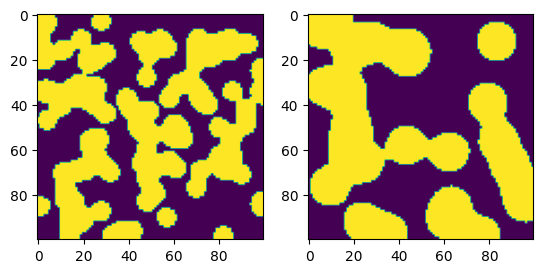

In [ ]:
## Power of PH as a feature extractor depends on the problem
## Let us perform a syhthetic experiment, where PH works well.

## create a classification problem consisting of random blobs of different size
from skimage import data
n = 100
X = [data.binary_blobs(length=100, blob_size_fraction=0.1).astype(np.float64) for i in range(n)]
X.extend([data.binary_blobs(length=100, blob_size_fraction=0.2) for i in range(n)])
Y = [0 for i in range(n)]
Y.extend([1 for i in range(n)])
plt.subplot(1,2,1)
plt.imshow(X[0])
plt.subplot(1,2,2)
plt.imshow(X[n])

### classification
max_life = 8
pixel_size = 1

pim = pimg.PersistenceImager(birth_range=(-max_life,max_life), pers_range=(0,max_life), pixel_size=pixel_size)
pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i]
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)-distance_transform_edt(~bw_img)
    pd = cripser.computePH(dt_img)    # compute PH of distance transform
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=-max_life,a_max=max_life) # clip min/max birth/death
    pds.append(pd)  
    pim0 = pim.transform(pd[pd[:,0]==0,1:3])
    pim1 = pim.transform(pd[pd[:,0]==1,1:3])
    pims_h0.append(pim0.ravel()) # vectorise by persistence image
    pims_h1.append(pim1.ravel()) # vectorise by persistence image

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


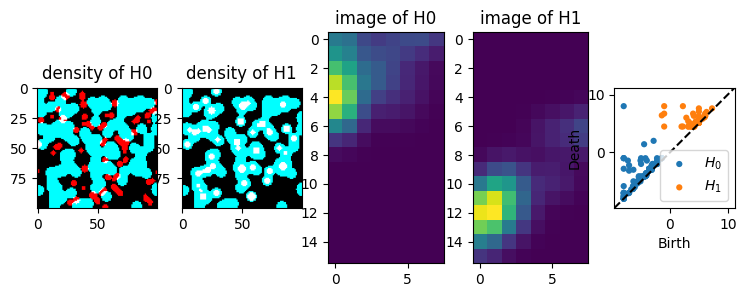

In [ ]:
# plot features extracted by persistent homology/persistence image for a digit
# x-axis: lifetime, y-axis: birth
k=0
img = X[k]*255
pd = pds[k]    # compute PH of distance transform

fig = plt.figure(figsize=(9,3))
for d in range(2):
  heat=heat_map(img,pd,h=5,sigma=1,min_life=0,max_life=max_life,min_birth =-max_life,max_birth = max_life,dimension=d,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  ax = fig.add_subplot(1,5,1+d)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density of H{}".format(d))
  ax = fig.add_subplot(1,5,d+3)
  ax.imshow(pim.transform(pd[pd[:,0]==d,1:3]))
  ax.set_title("image of H{}".format(d))
persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = fig.add_subplot(1,5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Important feature. birth around: 5.7142857142857135 lifetime around: 0.0


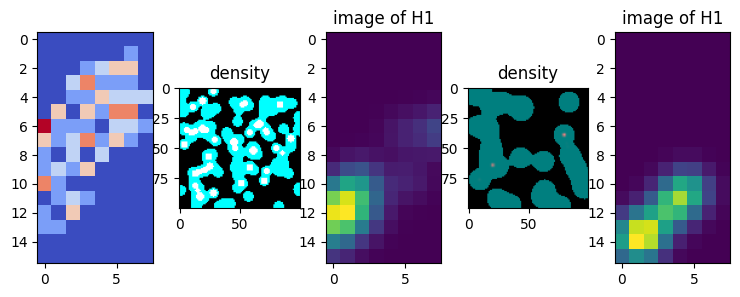

In [ ]:
## identify what variables have impact on the decision
# in this case, the region of the persistence image of H1 
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])

fig = plt.figure(figsize=(9,3))

ax = fig.add_subplot(1,5,1)
ax.imshow(clf.feature_importances_.reshape(pim1.shape),cmap='coolwarm')
most_important = np.unravel_index(indices[-1], shape=pim1.shape)
life,birth = np.meshgrid(np.linspace(0,max_life,pim1.shape[0]), np.linspace(-max_life,max_life,pim1.shape[1]))
b = birth[most_important]
l = life[most_important]
print("Important feature. birth around:", b,"lifetime around:", l)

# annotate the density of the most contributing feature on the image
# For demonstration, we pick one image from each class. 
# the annotation explains how the classifier discerns two classes
idx = [0,n]
for i in range(len(idx)):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  h = 3*pixel_size
  heat=heat_map(img,pd,h=5,sigma=1,min_life=l-h,max_life=l+h,min_birth =b-h,max_birth = b+h,dimension=d,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  ax = fig.add_subplot(1,5,2+i*2)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density")
  ax = fig.add_subplot(1,5,3+i*2)
  ax.imshow(pim.transform(pd[pd[:,0]==1,1:3]))
  ax.set_title("image of H{}".format(1))



##Clustering

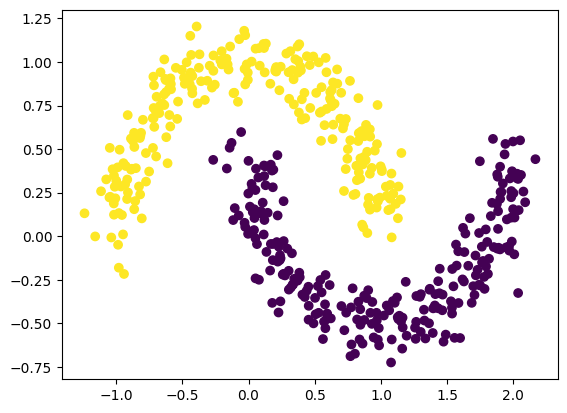

In [ ]:
## ToMATo (Topological Mode Analysis Tool)
# an interesting and less-known application of persistent homology is to clustering.
# input: graph with real values on vertices => clustering for vertices
import tomaster
import sklearn.datasets
X,_ = sklearn.datasets.make_moons(n_samples=500, noise=0.1)
clusters, _ = tomaster.tomato(X, k=10, n_clusters=2)
plt.scatter(*X.T, c=clusters)
# Compare the results in https://scikit-learn.org/stable/modules/clustering.html

0 1.674519764606817 1
0 0.8372598823034085 12
0 0.41862994115170427 38
0.20931497057585213 0.41862994115170427 25
0.20931497057585213 0.3139724558637782 28
0.20931497057585213 0.26164371321981517 31


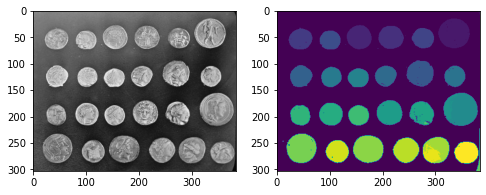

In [ ]:
## ToMaTo applied for image segmentation
# just for demonstration: there are better ways for ordinary segmentation tasks.
import skimage
img = skimage.data.coins()
clusters = tomaster.tomato_img(img, spatial_weight=1, k=10, n_clusters=30)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(clusters)


In [ ]:
## lightGBM is one of the most powerful and efficient regressor/classifier based on gradient boosting
#!conda install -c conda-forge lightgbm
